## Import the libraries and the DataReader

In [1]:
# All outputs are visible
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#Retina resolution for the plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
# All plots contained in the notebook
%matplotlib inline


In [2]:
from data.PlaylistDataReader import PlaylistDataReader
from utils.logger import Logger
from utils.config import clear, Configurator
import argparse



In [3]:
conf = Configurator("configs/item_knn_cbf.json")

data_reader = PlaylistDataReader()
data_reader.generate_datasets()



PlaylistDataReader: URM is imported from the saved data.
PlaylistDataReader: ICM is imported from the saved data.
PlaylistDataReader: URM train and test splits are imported from the saved data.


## Get the model Folders and Auxilary Method Implementations

In [222]:
from contextlib import contextmanager
import os
# function for changing directory
@contextmanager
def working_directory(directory):
    owd = os.getcwd()
    try:
        os.chdir(directory)
        yield directory
    finally:
        os.chdir(owd)

def getModelName(file):
    lst = file.split("/")
    return lst[1]
def getSimName(file,saved=False):
    if saved:
        index = -3
    else:
        index = -4
    simList = ["asymmetric","tversky","cosine","jaccard","dice"]
    lst = file.split("_")
    if lst[index] in simList:
        return lst[index]
    else:
        return "default"
    
def getUniqueModelList(fileList):
    models = [getModelName(i) for i in fileList]
    return list(set(models))

def packageWithModel(fileList,saved=False):
    model_file = []
    for file in fileList:
        added = (getModelName(file),file,getSimName(file,saved))
        model_file.append(added)
    return model_file

import os      
import re
filter = re.compile(r'\..+|.+\.txt$')
parameterFolder = "tuned_parameters"
listOfFolders = os.listdir(parameterFolder)
filteredDirPaths = [parameterFolder+"/"+i for i in listOfFolders if not filter.search(i)]
saved_parameterFolder = "saved_parameters"
listofParameters = os.listdir(saved_parameterFolder)
filteredSavedParameters = [saved_parameterFolder + "/" + i for i in listofParameters if not filter.search(i)]

In [207]:
filteredDirPaths

['tuned_parameters/Slim_Elastic_Net_Recommender',
 'tuned_parameters/UserKNNCFRecommender',
 'tuned_parameters/SLIM_BPR_Recommender_mark1',
 'tuned_parameters/ItemKNNCBFRecommender',
 'tuned_parameters/P3_Alpha_Recommender',
 'tuned_parameters/PureSVD',
 'tuned_parameters/ItemTreeRecommender_offline',
 'tuned_parameters/SLIM_BPR_Recommender_mark2',
 'tuned_parameters/RP3_Beta_Recommender',
 'tuned_parameters/ItemKNNCFRecommender']

# Get All the Files and Categorize them

In [245]:
best_models = []
best_model_parameters = []
best_results = []
files = []

# get all the files
for folder in filteredDirPaths:
    with working_directory(folder):
        filePaths = [folder +"/"+ i for i in os.listdir(".")]
        files.extend(filePaths)
        
# Define error filter
errorFilter = re.compile(r'Error.+')
# Make it error free
errorFilteredFiles = [i for i in files if not errorFilter.search(i)]
bestModelFilter = re.compile(r'best_model$')
modelFiles = [i for i in files if bestModelFilter.search(i)]
parameterFilter = re.compile(r'best_parameters$')
parameterFiles = [i for i in files if parameterFilter.search(i)]
resultFilter = re.compile(r'best_result_test$')
resultFiles = [i for i in files if resultFilter.search(i)]
modelFiles_t = packageWithModel(modelFiles)
parameterFiles_t = packageWithModel(parameterFiles)
resultFiles_t = packageWithModel(resultFiles)


In [246]:
modelsSoFar = getUniqueModelList(modelFiles)

## Get the saved Parameters

In [247]:
resultFiles_saved = packageWithModel(filteredSavedParameters,saved=True)

In [248]:
resultFiles_saved

[('SLIM_BPR_Recommender_mark1_best_parameters',
  'saved_parameters/SLIM_BPR_Recommender_mark1_best_parameters',
  'default'),
 ('RP3_Beta_Recommender_best_parameters',
  'saved_parameters/RP3_Beta_Recommender_best_parameters',
  'default'),
 ('P3_Alpha_Recommender_best_parameters',
  'saved_parameters/P3_Alpha_Recommender_best_parameters',
  'default'),
 ('ItemKNNCBFRecommender_cosine_best_parameters',
  'saved_parameters/ItemKNNCBFRecommender_cosine_best_parameters',
  'cosine'),
 ('ItemTreeRecommender_offline_best_parameters',
  'saved_parameters/ItemTreeRecommender_offline_best_parameters',
  'default'),
 ('UserKNNCFRecommender_tversky_best_parameters',
  'saved_parameters/UserKNNCFRecommender_tversky_best_parameters',
  'tversky'),
 ('ItemKNNCFRecommender_cosine_best_parameters',
  'saved_parameters/ItemKNNCFRecommender_cosine_best_parameters',
  'cosine')]

## Find all the map values of the Best Models

In [249]:
from utils.OfflineDataLoader import OfflineDataLoader
from models.KNN.User_KNN_CFRecommender import UserKNNCFRecommender
from models.KNN.Item_KNN_CFRecommender import ItemKNNCFRecommender
from models.KNN.Item_KNN_CBFRecommender import ItemKNNCBFRecommender
from models.graph.P3AlphaRecommender import P3alphaRecommender
from models.graph.RP3BetaRecommender import RP3betaRecommender
from models.Slim_mark1.Cython.Slim_BPR_Cython import Slim_BPR_Recommender_Cython

def printOutMapValues(modelList,URM,UCM,modelsSoFar):
    map_dict = {i:dict() for i in modelsSoFar}
    m = OfflineDataLoader()
    for model in modelList:
        folder = str("/".join(model[1].split("/")[:-1])+"/")
        file = model[1].split("/")[-1]
        if model[0] == "UserKNNCFRecommender":
            mod = UserKNNCFRecommender(URM)
            mod.loadModel(folder_path=folder,file_name=file,verbose=False)
            map_dict[model[0]][model[2]] = mod.MAP
            print(model[0], model[2],mod.MAP)
        elif model[0] == "ItemKNNCFRecommender":
            mod = ItemKNNCFRecommender(URM)
            mod.loadModel(folder_path=folder,file_name=file,verbose=False)
            map_dict[model[0]][model[2]] = mod.MAP
            print(model[0], model[2],mod.MAP)
        elif model[0] == "ItemKNNCBFRecommender":
            mod = ItemKNNCBFRecommender(URM,UCM)
            mod.loadModel(folder_path=folder,file_name=file,verbose=False)
            map_dict[model[0]][model[2]] = mod.MAP
            print(model[0], model[2],mod.MAP)
        elif model[0] == "SLIM_BPR_Recommender_mark1":
            mod = Slim_BPR_Recommender_Cython(URM)
            mod.loadModel(folder_path=folder,file_name=file,verbose=False)
            map_dict[model[0]][model[2]] = mod.MAP
            print(model[0], model[2],mod.MAP)
        elif model[0] == "RP3_Beta_Recommender":
            mod = RP3betaRecommender(URM)
            mod.loadModel(folder_path=folder,file_name=file,verbose=False)
            map_dict[model[0]][model[2]] = mod.MAP
            print(model[0], model[2],mod.MAP)
        elif model[0] == "P3_Alpha_Recommender":
            mod = P3alphaRecommender(URM)
            mod.loadModel(folder_path=folder,file_name=file,verbose=False)
            map_dict[model[0]][model[2]] = mod.MAP
            print(model[0], model[2],mod.MAP)
        elif model[0] == "PureSVD":
            mod = P3alphaRecommender(URM)
            mod.loadModel(folder_path=folder,file_name=file,verbose=False)
            map_dict[model[0]][model[2]] = mod.MAP
            print(model[0], model[2],mod.MAP)
        elif model[0] == "Slim_Elastic_Net_Recommender":
            mod = P3alphaRecommender(URM)
            mod.loadModel(folder_path=folder,file_name=file,verbose=False)
            map_dict[model[0]][model[2]] = mod.MAP
            print(model[0], model[2],mod.MAP)
        elif model[0] == "SLIM_BPR_Recommender_mark2":
            mod = P3alphaRecommender(URM)
            mod.loadModel(folder_path=folder,file_name=file,verbose=False)
            map_dict[model[0]][model[2]] = mod.MAP
            print(model[0], model[2],mod.MAP)
        
    return map_dict

In [250]:
a = printOutMapValues(resultFiles_t,data_reader.URM_train,data_reader.ICM,modelsSoFar)

Slim_Elastic_Net_Recommender default 8.99074074074074e-05
UserKNNCFRecommender asymmetric 0.0945501676902241
UserKNNCFRecommender tversky 0.09916801141660332
UserKNNCFRecommender cosine 0.09308573721340364
UserKNNCFRecommender jaccard 0.09870710122197038
UserKNNCFRecommender dice 0.09811223900856646
SLIM_BPR_Recommender_mark1 default 0.09533706067334359
ItemKNNCBFRecommender jaccard 0.045217410068657087
ItemKNNCBFRecommender asymmetric 0.04724069075963713
ItemKNNCBFRecommender cosine 0.047233551996724604
ItemKNNCBFRecommender dice 0.04515282665658843
P3_Alpha_Recommender default 0.103057790721844
PureSVD default 0.03208743994079095
SLIM_BPR_Recommender_mark2 default 0.07908572412761378
RP3_Beta_Recommender default 0.10393123242630366
ItemKNNCFRecommender dice 0.09613278963529867
ItemKNNCFRecommender jaccard 0.09579004448538653
ItemKNNCFRecommender asymmetric 0.10151167776832949
ItemKNNCFRecommender cosine 0.09949610989858927
ItemKNNCFRecommender tversky 0.0916798676146386


In [251]:
saved = printOutMapValues(resultFiles_saved,data_reader.URM_train,data_reader.ICM,modelsSoFar)

In [252]:
import json
print(json.dumps(a,sort_keys=True, indent=4))

{
    "ItemKNNCBFRecommender": {
        "asymmetric": 0.04724069075963713,
        "cosine": 0.047233551996724604,
        "dice": 0.04515282665658843,
        "jaccard": 0.045217410068657087
    },
    "ItemKNNCFRecommender": {
        "asymmetric": 0.10151167776832949,
        "cosine": 0.09949610989858927,
        "dice": 0.09613278963529867,
        "jaccard": 0.09579004448538653,
        "tversky": 0.0916798676146386
    },
    "ItemTreeRecommender_offline": {},
    "P3_Alpha_Recommender": {
        "default": 0.103057790721844
    },
    "PureSVD": {
        "default": 0.03208743994079095
    },
    "RP3_Beta_Recommender": {
        "default": 0.10393123242630366
    },
    "SLIM_BPR_Recommender_mark1": {
        "default": 0.09533706067334359
    },
    "SLIM_BPR_Recommender_mark2": {
        "default": 0.07908572412761378
    },
    "Slim_Elastic_Net_Recommender": {
        "default": 8.99074074074074e-05
    },
    "UserKNNCFRecommender": {
        "asymmetric": 0.09455016769

# Find all the max MAPS

In [253]:

def create_mapMax(model_dict):
    model_map_list = []
    import operator
    for model in sorted(list(model_dict.keys())):
        sorted_by_value = sorted(model_dict[model].items(), key=lambda kv: kv[1],reverse=True)
        if len(sorted_by_value) != 0:
            model_map_list.append((model,(sorted_by_value[0])))
    return model_map_list


In [254]:
b = create_mapMax(a)
b

[('ItemKNNCBFRecommender', ('asymmetric', 0.04724069075963713)),
 ('ItemKNNCFRecommender', ('asymmetric', 0.10151167776832949)),
 ('P3_Alpha_Recommender', ('default', 0.103057790721844)),
 ('PureSVD', ('default', 0.03208743994079095)),
 ('RP3_Beta_Recommender', ('default', 0.10393123242630366)),
 ('SLIM_BPR_Recommender_mark1', ('default', 0.09533706067334359)),
 ('SLIM_BPR_Recommender_mark2', ('default', 0.07908572412761378)),
 ('Slim_Elastic_Net_Recommender', ('default', 8.99074074074074e-05)),
 ('UserKNNCFRecommender', ('tversky', 0.09916801141660332))]

## Profile Grouping

In [4]:
import numpy as np
import scipy.sparse as sps
URM_train = sps.csr_matrix(data_reader.URM_train)

profile_length = np.ediff1d(URM_train.indptr)

block_size = int(len(profile_length)* (1/22))
block_size

2293

In [5]:
sorted_users = np.argsort(profile_length )

In [6]:
for group_id in range(0, 22):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, group size: {} average p.len {:.2f}, min {}, max {}".format(group_id,len(users_in_group),
        users_in_group_p_len.mean(), users_in_group_p_len.min(), users_in_group_p_len.max()))

Group 0, group size: 2293 average p.len 5.06, min 2, max 6
Group 1, group size: 2293 average p.len 6.11, min 6, max 7
Group 2, group size: 2293 average p.len 7.11, min 7, max 8
Group 3, group size: 2293 average p.len 8.12, min 8, max 9
Group 4, group size: 2293 average p.len 9.18, min 9, max 10
Group 5, group size: 2293 average p.len 10.41, min 10, max 11
Group 6, group size: 2293 average p.len 11.64, min 11, max 12
Group 7, group size: 2293 average p.len 13.15, min 12, max 14
Group 8, group size: 2293 average p.len 14.54, min 14, max 15
Group 9, group size: 2293 average p.len 16.19, min 15, max 17
Group 10, group size: 2293 average p.len 17.82, min 17, max 19
Group 11, group size: 2293 average p.len 19.61, min 19, max 21
Group 12, group size: 2293 average p.len 21.61, min 21, max 23
Group 13, group size: 2293 average p.len 23.68, min 23, max 25
Group 14, group size: 2293 average p.len 25.98, min 25, max 27
Group 15, group size: 2293 average p.len 28.66, min 27, max 30
Group 16, group 

In [56]:
import numpy as np
from utils.OfflineDataLoader import OfflineDataLoader
m = OfflineDataLoader()

from models.Slim_mark2.Cython.Slim_BPR_Cython import Slim_BPR_Recommender_Cython as slim_mark2
from models.KNN.Item_KNN_CBFRecommender import ItemKNNCBFRecommender
m1 = slim_mark2(data_reader.URM_train)
m2 = ItemKNNCBFRecommender(data_reader.URM_train,data_reader.ICM)
fold ,file = m.get_model(slim_mark2.RECOMMENDER_NAME)
m1.loadModel(folder_path = fold, file_name=file)
fold ,file = m.get_model(ItemKNNCBFRecommender.RECOMMENDER_NAME)
m2.loadModel(folder_path = fold, file_name=file)

SLIM_BPR_Cython: Estimated memory required for similarity matrix of 20635 items is 1703.21 MB
SLIM_BPR_Recommender_mark2: Loading model from file 'saved_models/training/SLIM_BPR_Recommender_mark2'
SLIM_BPR_Recommender_mark2: Loading complete
ItemKNNCBFRecommender: Loading model from file 'saved_models/training/ItemKNNCBFRecommender_asymmetric_best_model'
ItemKNNCBFRecommender: Loading complete


'SLIM_BPR_Recommender_mark2'

In [34]:
W_sparse_CF = m1.W_sparse
W_sparse_CBF = m2.W_sparse
W_sparse_CF_sorted = np.sort(W_sparse_CF.data.copy())
W_sparse_CBF_sorted = np.sort(W_sparse_CBF.data.copy())

Text(0, 0.5, 'Similarity cell ')

Text(0.5, 0, 'Similarity value')

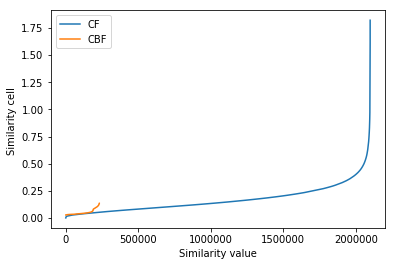

In [10]:
import numpy as np
import matplotlib.pyplot as pyplot


pyplot.plot(W_sparse_CF_sorted, label = 'CF')
pyplot.plot(W_sparse_CBF_sorted, label = 'CBF')
pyplot.ylabel('Similarity cell ')
pyplot.xlabel('Similarity value')
pyplot.legend()
pyplot.show()

In [11]:
# Get common structure
W_sparse_CF_structure = W_sparse_CF.copy()
W_sparse_CF_structure.data = np.ones_like(W_sparse_CF_structure.data)

W_sparse_CBF_structure = W_sparse_CBF.copy()
W_sparse_CBF_structure.data = np.ones_like(W_sparse_CBF_structure.data)

W_sparse_common = W_sparse_CF_structure.multiply(W_sparse_CBF_structure)

# Get values of both in common structure of CF
W_sparse_delta = W_sparse_CBF.copy().multiply(W_sparse_common)
W_sparse_delta -= W_sparse_CF.copy().multiply(W_sparse_common)

Text(0, 0.5, 'Similarity cell ')

Text(0.5, 0, 'Similarity value')

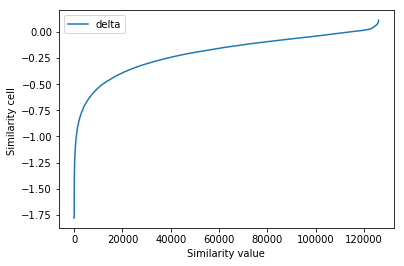

In [12]:
W_sparse_delta_sorted = np.sort(W_sparse_delta.data.copy())
pyplot.plot(W_sparse_delta_sorted, label = 'delta')
pyplot.ylabel('Similarity cell ')
pyplot.xlabel('Similarity value')
pyplot.legend()
pyplot.show()

In [13]:
# How many values we have in common?

print("W_sparse_CF has {:.2E} values and {:.2f} % in common with CBF".format(W_sparse_CF.nnz, W_sparse_common.nnz/W_sparse_CF.nnz*100))
print("W_sparse_CBF has {:.2E} values and {:.2f} % in common with CF".format(W_sparse_CBF.nnz, W_sparse_common.nnz/W_sparse_CBF.nnz*100))

print("W_sparse_delta has {:.2E} values".format(W_sparse_delta.nnz))



W_sparse_CF has 2.10E+06 values and 6.00 % in common with CBF
W_sparse_CBF has 2.31E+05 values and 54.58 % in common with CF
W_sparse_delta has 1.26E+05 values


In [14]:
W_sparse_delta = W_sparse_delta.tocoo()


item_index_1 = W_sparse_delta.row[666]
item_index_2 = W_sparse_delta.col[666]

In [15]:
print("Item indices are {} and {}".format(item_index_1, item_index_2))

Item indices are 110 and 16594


In [16]:
print("Collaborative similarity value is {}".format(W_sparse_CF[item_index_1, item_index_2]))
print("Content-based similarity value is {}".format(W_sparse_CBF[item_index_1, item_index_2]))

Collaborative similarity value is 0.24627837538719177
Content-based similarity value is 0.09742043912410736


In [17]:
from base.RecommenderUtils import check_matrix
ICM = check_matrix(data_reader.ICM,"csr")
common_features = ICM[item_index_1,:].multiply(ICM[item_index_2,:])
common_features

<1x19412 sparse matrix of type '<class 'numpy.float32'>'
	with 2 stored elements in Compressed Sparse Row format>

In [18]:
common_features.indices

array([1092, 8876], dtype=int32)

In [19]:
min_common_features = 5

for inner_index in range(len(W_sparse_delta.row)):

    item_index_1 = W_sparse_delta.row[inner_index]
    item_index_2 = W_sparse_delta.col[inner_index]

    common_features = ICM[item_index_1,:].multiply(ICM[item_index_2,:])
    
    if common_features.nnz >= min_common_features:
        
        # Bad programming, don't do this at home
        break
        
        

print("Item indices are {} and {}".format(item_index_1, item_index_2))

print("Collaborative similarity value is {}".format(W_sparse_CF[item_index_1, item_index_2]))
print("Content-based similarity value is {}".format(W_sparse_CBF[item_index_1, item_index_2]))
    
common_features.indices

Item indices are 20634 and 20038
Collaborative similarity value is 0.3328789472579956
Content-based similarity value is 0.04442018270492554


array([56], dtype=int32)

In [22]:
from scipy.sparse import linalg

loss_tolerance = 1e-6
iteration_limit = 50000
damp_coeff=0.0

W_sparse_CF_value = W_sparse_CF[item_index_1, item_index_2]

In [23]:
linalg_result = linalg.lsqr(common_features, W_sparse_CF_value, show = False, atol=loss_tolerance, btol=loss_tolerance,
                  iter_lim = iteration_limit, damp=damp_coeff)

In [24]:
feature_weights = linalg_result[0].copy()
feature_weights

array([0., 0., 0., ..., 0., 0., 0.])

In [25]:
feature_weights[common_features.indices]

array([0.33287895])

In [26]:
new_CBF_value = common_features.dot(feature_weights)
new_CBF_value

array([0.33287895])

In [27]:
print("Collaborative similarity value is {}".format(W_sparse_CF[item_index_1, item_index_2]))
print("Content-based similarity value is {}".format(W_sparse_CBF[item_index_1, item_index_2]))

print("Weighted Content-based similarity value is {}".format(new_CBF_value[0]))

Collaborative similarity value is 0.3328789472579956
Content-based similarity value is 0.04442018270492554
Weighted Content-based similarity value is 0.3328789472579956


In [57]:
from models.FW_Similarity.CFWBoostingRecommender import CFWBoostingRecommender 

In [60]:
data_reader.get_URM_train().tocsr()

<50446x20635 sparse matrix of type '<class 'numpy.int64'>'
	with 1164922 stored elements in Compressed Sparse Row format>

In [63]:
CFW_weigthing = CFWBoostingRecommender(data_reader.get_URM_train(), data_reader.ICM, slim_mark2.__class__ ,training=True)
CFW_weigthing.fit()

AttributeError: type object 'type' has no attribute 'RECOMMENDER_NAME'

In [27]:
from base.evaluation.Evaluator import SequentialEvaluator

evaluator_validation = SequentialEvaluator(data_reader.URM_test, cutoff_list=[10])
evaluator_test = SequentialEvaluator(data_reader.URM_test, cutoff_list=[10])



In [30]:
results_dict, _ = evaluator_test.evaluateRecommender(m1)
results_dict

SequentialEvaluator: Processed 7001 ( 70.01% ) in 32.60 seconds. Users per second: 215
SequentialEvaluator: Processed 10000 ( 100.00% ) in 39.37 seconds. Users per second: 254


{10: {'MAP': 0.09805901510141089,
  'PRECISION': 0.19725876984126867,
  'RECALL': 0.19516547211689153}}

In [31]:
results_dict, _ = evaluator_test.evaluateRecommender(m2)
results_dict

SequentialEvaluator: Processed 9001 ( 90.01% ) in 31.54 seconds. Users per second: 285
SequentialEvaluator: Processed 10000 ( 100.00% ) in 31.79 seconds. Users per second: 315


{10: {'MAP': 0.048737593616150016,
  'PRECISION': 0.10162825396825478,
  'RECALL': 0.1009123736639185}}

In [33]:
results_dict, _ = evaluator_test.evaluateRecommender(CFW_weigthing)
results_dict

SequentialEvaluator: Processed 8001 ( 80.01% ) in 30.76 seconds. Users per second: 260
SequentialEvaluator: Processed 10000 ( 100.00% ) in 34.19 seconds. Users per second: 293


{10: {'MAP': 0.0420240052437641,
  'PRECISION': 0.0912482936507941,
  'RECALL': 0.09064340574458254}}

In [34]:
from parameter_tuning.BayesianSearch import BayesianSearch
from parameter_tuning.AbstractClassSearch import DictionaryKeys

from parameter_tuning.AbstractClassSearch import EvaluatorWrapper


evaluator_validation_tuning = EvaluatorWrapper(evaluator_validation)
evaluator_test_tuning = EvaluatorWrapper(evaluator_test)


recommender_class = CFW_D_Similarity_Linalg

parameterSearch = BayesianSearch(recommender_class,
                                 evaluator_validation=evaluator_validation_tuning,
                                 evaluator_test=evaluator_test_tuning)


hyperparamethers_range_dictionary = {}
hyperparamethers_range_dictionary["topK"] = [5, 10, 20, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800]
hyperparamethers_range_dictionary["add_zeros_quota"] = range(0,1)
hyperparamethers_range_dictionary["normalize_similarity"] = [True, False]



recommenderDictionary = {DictionaryKeys.CONSTRUCTOR_POSITIONAL_ARGS: [data_reader.URM_train, ICM, W_sparse_CF],
                         DictionaryKeys.CONSTRUCTOR_KEYWORD_ARGS: {},
                         DictionaryKeys.FIT_POSITIONAL_ARGS: dict(),
                         DictionaryKeys.FIT_KEYWORD_ARGS: dict(),
                         DictionaryKeys.FIT_RANGE_KEYWORD_ARGS: hyperparamethers_range_dictionary}


output_root_path = "result_experiments/ICM_genres/"

import os

# If directory does not exist, create
if not os.path.exists(output_root_path):
    os.makedirs(output_root_path)

    
output_root_path += recommender_class.RECOMMENDER_NAME      
    
n_cases = 20
metric_to_optimize = "MAP"

best_parameters_CFW_D = parameterSearch.search(recommenderDictionary,
                                                 n_cases = n_cases,
                                                 output_root_path = output_root_path,
                                                 metric=metric_to_optimize)



|   iter    |  target   | add_ze... | normal... |   topK    |
-------------------------------------------------------------
BayesianSearch: Testing config: {'add_zeros_quota': 0.10001026716733641, 'normalize_similarity': False, 'topK': 400}
CFW_D_Similarity_Linalg: Generating train data
Similarity column 20635 ( 100 % ), 9314.11 column/sec, elapsed time 0.04 min
CFW_D_Similarity_Linalg: Collaborative S density: 9.46E-04, nonzero cells 402784
CFW_D_Similarity_Linalg: Content S density: 5.43E-04, nonzero cells 231010
CFW_D_Similarity_Linalg: Content S structure has 69352 out of 231010 ( 30.02%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 1.57E+04, average is: 2.26E-01, average over all collaborative data is 1.72E-01
Similarity column 20635 ( 100 % ), 9758.82 column/sec, elapsed time 0.04 min
SequentialEvaluator: Processed 8811 ( 88.11% ) in 30.00 seconds. Users per second: 294
SequentialEvaluator: Processed 10000 ( 100.00% ) in 33.22 seconds. U

TypeError: list indices must be integers or slices, not str